### Violence Detection in Videos

#### Transfer Learning Project

##### Seda Unal - Insight Data Science, Palo Alto. June 2017



In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.models import load_model

import h5py

import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score




Using TensorFlow backend.


In [2]:
size_of_batch = 32

# all images will be resized to 299x299 as required by Inception
img_width = 299
img_height = 299

nb_epoch = 10

Generate batches of tensor image data with real-time data augmentation. 
The data will be looped over (in batches) indefinitely.
class_mode: Determines the type of label arrays that are returned: "categorical" will be 2D one-hot encoded labels


In [3]:
''' Few Data points might lead to overfitting / high variance. Augmentation aka random transformations 
makes sure the model will never see the exact same image twice, hence, the model will generalize better. '''

traindatagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 45,
        width_shift_range  = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range  = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

valdatagen = ImageDataGenerator(rescale = 1./255)

In [4]:
train_generator = traindatagen.flow_from_directory(
        directory = 'train', 
        shuffle   = True,
        target_size = (img_width, img_height), 
        batch_size  = size_of_batch,
        class_mode  = 'categorical')  

Found 7244 images belonging to 2 classes.


In [5]:
val_generator = valdatagen.flow_from_directory(
        directory = 'validation', 
        shuffle = False,
        target_size = (img_width, img_height),
        batch_size = size_of_batch,
        class_mode = 'categorical')  

Found 1878 images belonging to 2 classes.


#### Pre-trained Inception Model

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False)

''' The fully connected top layer is truncated for re-training purposes 
Inception Model is not sequential, therefore weights on layers cannot be frozen. 
However, since pretrained weights are stored in the layers but not in the model
a fully connected softmax layer on top of last Inception module will learn the new features. '''

x = base_model.output

#### Transfer Learning

In [7]:
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

#### Classification (Softmax) Layer

In [8]:
predictions = Dense(2, activation='softmax')(x)

#### Re-training

In [9]:
model = Model(inputs = base_model.input, outputs = predictions)

In [10]:
''' Freeze all Conv layers as Inception is re-trained via the fully connected layer '''
for layer in base_model.layers:
    layer.trainable = False

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)

TrainingLogs = model.fit_generator(
        train_generator,
        steps_per_epoch  = train_steps_per_epoch,
        validation_data  = val_generator,
        validation_steps = validation_steps_per_epoch,
        epochs = nb_epoch,
        callbacks = [early_stopping],
        verbose = 1,
        pickle_safe = False
)

Epoch 1/10
226/226 [==============================] - 156s - loss: 0.2417 - acc: 0.9115 - val_loss: 0.8158 - val_acc: 0.6659

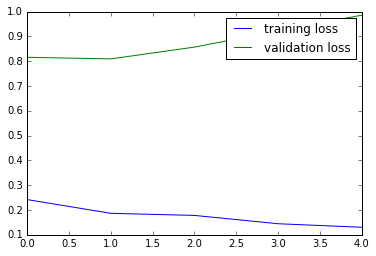

In [15]:
plt.plot(TrainingLogs.history['loss'],label='training loss')
plt.plot(TrainingLogs.history['val_loss'],label='validation loss')
plt.legend()

#### Testing

##### on all the frames from all the test videos

In [16]:
heldout = valdatagen.flow_from_directory(directory='test', 
        target_size = (img_width, img_height),
        batch_size = size_of_batch,
        class_mode='categorical') 

Found 2294 images belonging to 2 classes.


In [17]:
test_steps = np.math.ceil(heldout.samples / heldout.batch_size)
res = model.evaluate_generator(heldout, steps=test_steps, max_q_size=10, workers=1, pickle_safe=False)

print(model.metrics_names, '\n',res)

(['loss', 'acc'], '\n', [0.52011276739583889, 0.78345070422535212])


##### on a single test video

In [30]:
VideoBatch1 = valdatagen.flow_from_directory(directory='SampleVideos/video3/Frames/', 
        target_size = (img_width,img_height),  
        batch_size = 2) 

steps1 = np.math.ceil(VideoBatch1.samples // VideoBatch1.batch_size)
video1_prob = model.predict_generator(VideoBatch1, steps=steps1)
video1_violent_content = np.argmax(video1_prob, axis=1).sum()/len(video1_prob)

predictions = video1_prob
predicted_classes = np.argmax(video1_prob, axis=1)
true_classes = VideoBatch1.classes
class_labels = list(VideoBatch1.class_indices.keys())   


Found 38 images belonging to 2 classes.


#### Test Results

In [31]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

             precision    recall  f1-score   support

NonViolence       0.42      0.71      0.53        14
   Violence       0.71      0.42      0.53        24

avg / total       0.60      0.53      0.53        38



In [21]:
res = model.evaluate_generator(VideoBatch1, steps=steps1, max_q_size=10, workers=1, pickle_safe=False)
print(model.metrics_names, '\n',res)

(['loss', 'acc'], '\n', [0.80080739736557005, 0.63200001358985902])


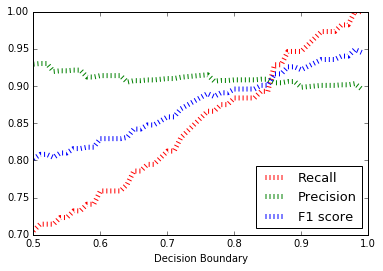

In [22]:
def Plot_Metrics(my_threshold):
    Recall = np.zeros(len(my_threshold))
    Precision = np.zeros(len(my_threshold))
    F1 = np.zeros(len(my_threshold))
    
    for j in range(len(my_threshold)):
        my_thre = my_threshold[j]
        my_predicted_classes = []
        for i in range(len(predictions)):
            if predictions[i][0] > my_thre: #1st i NonViolence 
                my_predicted_classes.append(0)
            else:
                my_predicted_classes.append(1)

        my_predicted_classes = np.array(my_predicted_classes)
        Recall[j] = recall_score(true_classes, my_predicted_classes, labels=class_labels, pos_label=1, average='binary', sample_weight=None)
        Precision[j] = precision_score(true_classes, my_predicted_classes, labels=class_labels, pos_label=1, average='binary', sample_weight=None)
        F1[j] = f1_score(true_classes, my_predicted_classes, labels=class_labels, pos_label=1, average='binary', sample_weight=None)
    fig = plt.figure()
    plt.style.use('seaborn-bright') 
    plt.plot(my_threshold, Recall, 'r:', label='Recall', linewidth=5)
    plt.plot(my_threshold, Precision, 'g:', label='Precision', linewidth=5)
    plt.plot(my_threshold, F1, 'b:', label='F1 score', linewidth=5)
    plt.xlabel('Decision Boundary')
    plt.xlim([0.5, 1])
    plt.legend(loc='best', prop={'family':'sans', 'size':'13'})
    fig.savefig('test1_metrics.png', dpi=fig.dpi)

    return Precision


my_threshold = np.linspace(0.5, 0.99)
pre = Plot_Metrics(my_threshold)

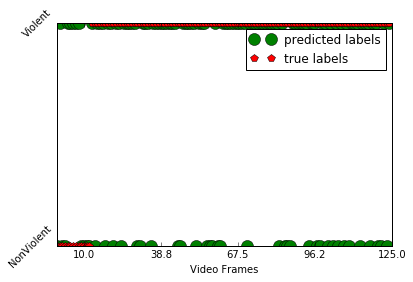

In [23]:
fig = plt.figure()

plt.plot(predicted_classes,'go',label='predicted labels',markersize=12)
plt.plot(true_classes,'rp', label='true labels',markersize=8)
ax = plt.gca()

ax.set_yticks(ticks=[0,1])
ax.set_yticklabels(labels=['NonViolent','Violent'],rotation=45)
plt.legend()
plt.xticks(np.linspace(10,len(predicted_classes),5))
plt.xlim([0,len(predicted_classes)])
plt.xlabel('Video Frames')

fig.savefig('test1_predictions.png', dpi=fig.dpi)




In [24]:
model.save_weights("model_sgd.h5")
print("Saved model to disk")

#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

Saved model to disk


How to fight with overfitting :

Grid Search with

- Learning rate 
- Batch Size, Epochs
- Dropout ratio
- Optimiser